In [4]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [5]:
path = 'Data/Variants/Infected/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


0.2717666119434923


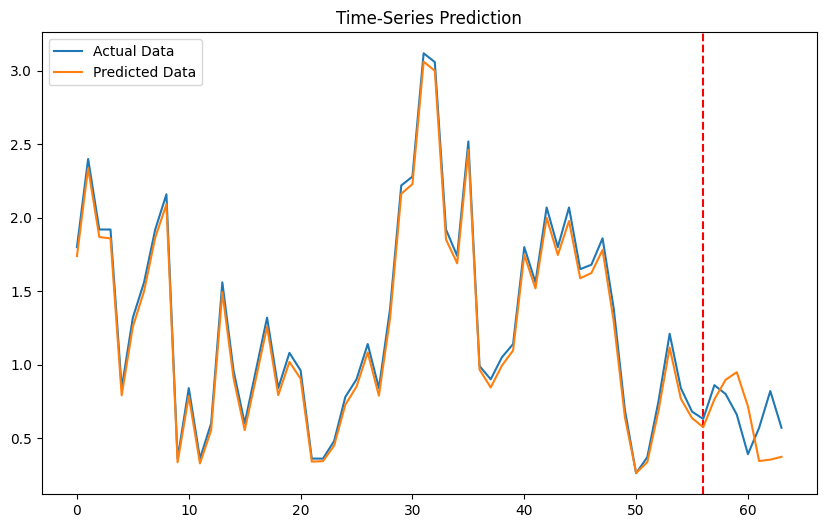

In [59]:
data = dic_files['대구']

df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

lr = 1e-4
patience = 50
num_layers = 1
batch_size = 32
hidden_size = 16
dropout = 0.25

x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')

model = BiLSTM(input_size = input_size,
               hidden_size = hidden_size,
               sequence_length = sequence_length,
               num_layers = num_layers, 
               dropout = dropout, 
               device = device).to(device)

optimizer = Adam(model.parameters(), lr = lr)

loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                              test_loader, 
                                              model, 
                                              criterion, 
                                              optimizer, 
                                              num_epochs, 
                                              patience,
                                              device)

label_y, predicted = predict_mto(model, df, x_ss, y_ms)

print(rmse(label_y[-7:], predicted[-7:]))
plotting(label_y, predicted, 56)

In [64]:
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([label_y, predicted], axis = 1), columns = ['Alpha_origin', 'Alpha_Predicted'])
df_predicted.index = list(data['stdDay'][-1*len(predicted):])
df_predicted.to_csv(f'Data/Predicted/Variants/Infected/{city}/alpha_{best_model}.csv')

df_predicted

,Alpha_origin,Alpha_Predicted
2021-06-13,1.80,1.738984
2021-06-14,2.40,2.337804
2021-06-15,1.92,1.868610
2021-06-16,1.92,1.859547
2021-06-17,0.84,0.791216
...,...,...
2021-08-11,0.66,0.948614
2021-08-12,0.39,0.715907
2021-08-13,0.57,0.343376
2021-08-14,0.82,0.352931


In [5]:
best_model

{'RNN': [0.07202486256580852,
  RNN(
    (rnn): RNN(3, 16, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=960, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  [0.006678621983155608,
   0.003252063412219286,
   0.0019303652225062251,
   0.0018279770156368613,
   0.001985373964998871,
   0.0019017160520888865,
   0.0016090315766632557,
   0.0012936952989548445,
   0.00107100565219298,
   0.0009645657555665821,
   0.0009264576947316527,
   0.0008799962524790317,
   0.0007929023122414947,
   0.0006811600469518453,
   0.000580466294195503,
   0.0005105877062305808,
   0.00046875046973582357,
   0.0004349190276116133,
   0.00039252344868145883,
   0.00034439984301570803,
   0.00030319254437927157,
   0.00027419910475146025,
   0.0002533234510337934,
   0.00023237397545017302,
   0.00020876907365163788,
   0.00018751319112197962,
   0.00017070965986

In [6]:
save_model(best_model['RNN'][1].state_dict(), "model/Infected/alpha/RNN.pth")
save_hyperparameter(best_model['RNN'][3:], "hyperparameter/Infected/alpha/RNN.pkl")

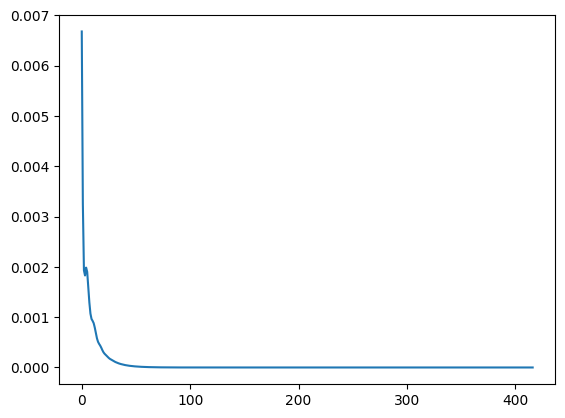

In [7]:
plt.plot(best_model['RNN'][2])

In [8]:
label_y, predicted = predict_mto(best_model['RNN'][1], df, x_ss, y_ms)

0.07202486256580852


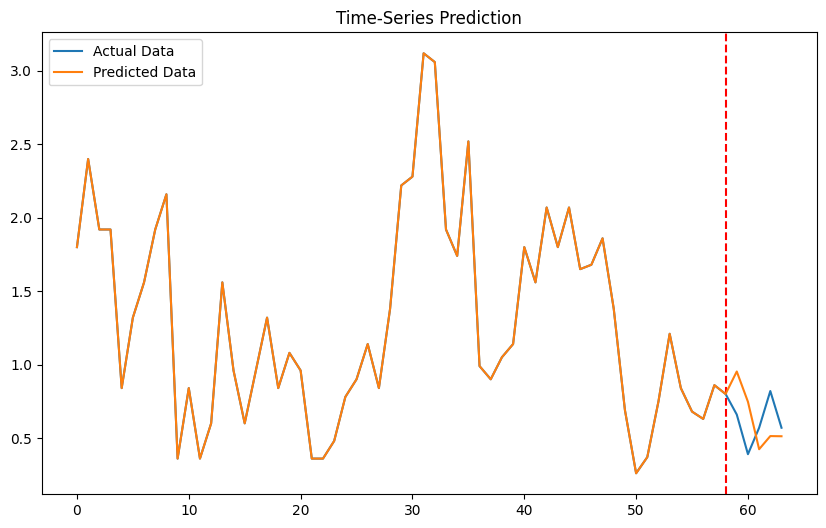

In [9]:
print(rmse(label_y[-7:], predicted[-7:]))
plotting(label_y, predicted, 58)